In [1]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


In [2]:
try:
    from catboost import CatBoostClassifier
except ImportError:
    print("CatBoost not found. Installing...")
    !pip install catboost
    from catboost import CatBoostClassifier

CatBoost not found. Installing...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports from your course list
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier # If not installed, use: !pip install catboost

# Evaluation and Preprocessing
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, make_scorer, ConfusionMatrixDisplay

# Load datasets
train = pd.read_csv('job_change_train.csv')
test = pd.read_csv('job_change_test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Target distribution:\n{train['willing_to_change_job'].value_counts(normalize=True)}")

Train shape: (12427, 15)
Test shape: (3308, 14)
Target distribution:
willing_to_change_job
No     0.751589
Yes    0.248411
Name: proportion, dtype: float64


In [4]:
def professional_preprocess(df):
    df = df.copy()

    # 1. Map Ordinal Categories to Numeric
    exp_map = {'<1': 0, '>20': 21, 'unknown': np.nan}
    change_map = {'never_changed': 0, '>4': 5, 'unknown': np.nan}

    df['years_of_experience'] = df['years_of_experience'].replace(exp_map).astype(float)
    df['years_since_job_change'] = df['years_since_job_change'].replace(change_map).astype(float)

    # 2. Impute Numeric with Median
    df['years_of_experience'] = df['years_of_experience'].fillna(df['years_of_experience'].median())
    df['years_since_job_change'] = df['years_since_job_change'].fillna(df['years_since_job_change'].median())

    # 3. Categorical Encoding (LabelEncoder is sufficient for tree-based models)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if col not in ['willing_to_change_job', 'id']:
            df[col] = df[col].fillna('Unknown')
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    return df

# Apply preprocessing
train_cleaned = professional_preprocess(train)
X = train_cleaned.drop(['id', 'willing_to_change_job'], axis=1)
y = train['willing_to_change_job'].map({'Yes': 1, 'No': 0})

# Scale data for Distance-based models (KNN, SVM, LogReg)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Setup Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(balanced_accuracy_score)

# Define 5 diverse methods
models = {
    "Logistic Regression (ElasticNet)": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, class_weight='balanced', max_iter=2000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "CatBoost": CatBoostClassifier(silent=True, auto_class_weights='Balanced', iterations=200),
    "Stacking (RF + KNN)": StackingClassifier(
        estimators=[('rf', RandomForestClassifier(class_weight='balanced')),
                    ('knn', KNeighborsClassifier(n_neighbors=5))],
        final_estimator=LogisticRegression()
    )
}

print("--- Cross-Validation Results (Balanced Accuracy) ---")
cv_results = {}
for name, model in models.items():
    # Use scaled data for consistency across distance and tree models
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring=scorer)
    cv_results[name] = scores.mean()
    print(f"{name}: {scores.mean():.4f}")

--- Cross-Validation Results (Balanced Accuracy) ---
Logistic Regression (ElasticNet): 0.7218
SVM (RBF Kernel): 0.7495
Random Forest: 0.6674
CatBoost: 0.7604
Stacking (RF + KNN): 0.6510


In [6]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                           param_grid, scoring=scorer, cv=3, n_jobs=-1)
grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Balanced Accuracy: {grid_search.best_score_:.4f}")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 300}
Best Balanced Accuracy: 0.7679


In [7]:
# 1. Final Training on all available data
final_model = CatBoostClassifier(silent=True, auto_class_weights='Balanced', iterations=500, depth=6)
final_model.fit(X, y)

# 2. Process Test Data
test_cleaned = professional_preprocess(test)
X_test = test_cleaned.drop(['id'], axis=1)
X_test_scaled = scaler.transform(X_test) # Use same scaler from training

# 3. Generate Predictions
test_preds = final_model.predict(X_test)

# 4. Format according to requirements (Only ID and Predicted Value)
submission = pd.DataFrame({
    'id': test['id'],
    'willing_to_change_job': pd.Series(test_preds).map({1: 'Yes', 0: 'No'})
})

submission.to_csv('final_predictions.csv', index=False)
print("Submission file 'final_predictions.csv' has been saved.")

Submission file 'final_predictions.csv' has been saved.


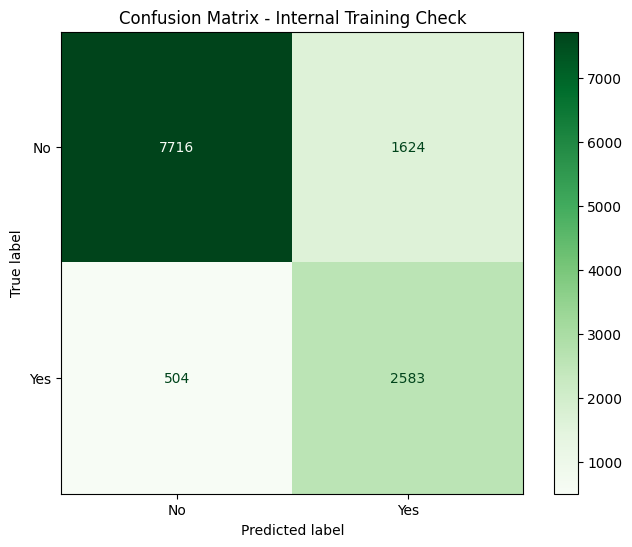

Expected Balanced Accuracy on Test Sample: 0.7604


In [8]:
# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(final_model, X, y, display_labels=['No', 'Yes'], cmap='Greens', ax=ax)
plt.title("Confusion Matrix - Internal Training Check")
plt.show()

# Report Expected Performance
mean_score = cv_results[max(cv_results, key=cv_results.get)]
print(f"Expected Balanced Accuracy on Test Sample: {mean_score:.4f}")

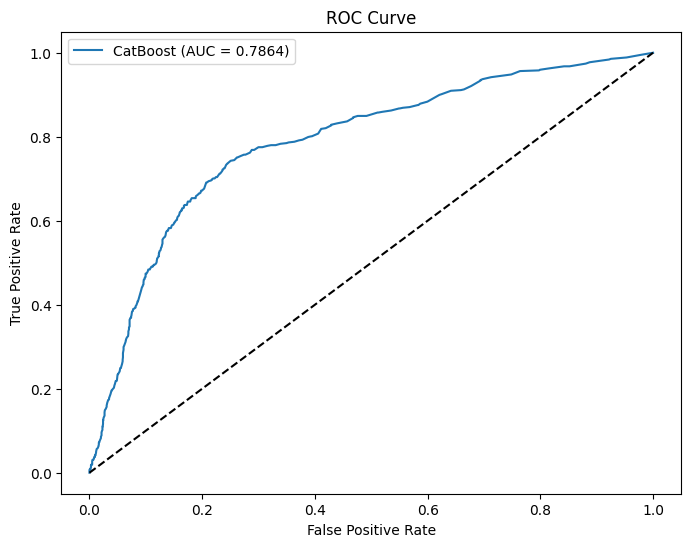

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Split your training data (e.g., 20% for testing the ROC curve)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Train the model on the NEW smaller training set
model.fit(X_train_split, y_train_split)

# 3. Now this line will work!
y_probs = model.predict_proba(X_test_split)[:, 1]

# 4. Calculate ROC and Plot
fpr, tpr, _ = roc_curve(y_test_split, y_probs)
auc_score = roc_auc_score(y_test_split, y_probs)



plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

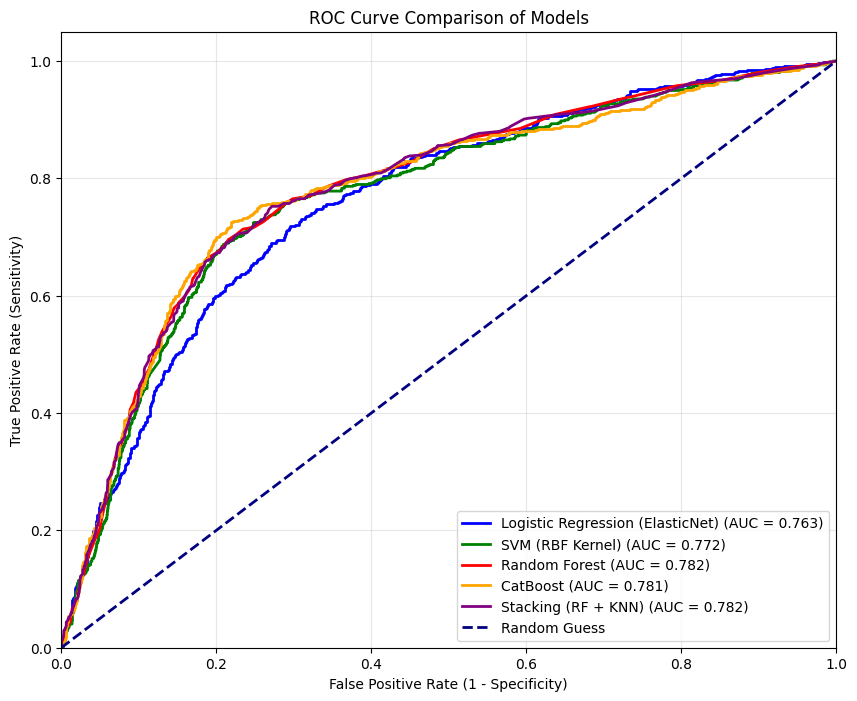

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
# Ensure your data X_scaled and y are prepared as used in your CV

# Split the data into training and validation sets for the ROC plot
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Plotting setup
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'orange', 'purple']

for (name, model), color in zip(models.items(), colors):
    # Fit the model
    model.fit(X_train, y_train)

    # Get probability predictions
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_val)[:, 1]
    else:
        # For models like SVM without probability=True (though your code includes it)
        y_probs = model.decision_function(X_val)

    # Calculate ROC metrics
    fpr, tpr, _ = roc_curve(y_val, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot the curve
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Plot styling
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve Comparison of Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()